In [56]:
import pandas as pd
import numpy as np
import json
import os

from statsmodels.robust import mad
import os

from sklearn.linear_model import LassoLarsIC, Lasso
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc

rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

In [58]:
smp_da_data = pd.read_csv('../data/제주전력시장_시장전기가격_하루전가격.csv')
smp_rc_data = pd.read_csv('../data/제주전력시장_시장전기가격_실시간가격.csv')
supply_data = pd.read_csv('../data/제주전력시장_현황데이터.csv')
weather_rdata1 = pd.read_csv('../data/기상실측데이터_1.csv')
weather_rdata2 = pd.read_csv('../data/기상실측데이터_2.csv')
weather_fdata1 = pd.read_csv('../data/기상예측데이터_1.csv')
weather_fdata2 = pd.read_csv('../data/기상예측데이터_2.csv')

In [59]:
class MedianScaler(object):

    def __init__(self):
        self.fitted = False

    def fit(self, data):

        if len(data.shape)!=2:
            raise IndexError('Error: Provide 2-D array. First dimension is datapoints and' + 
                  ' second features')
            return -1

        self.median = np.median(data, axis=0)
        self.mad = mad(data, axis=0)
        self.fitted = True
        
    def fit_transform(self, data):

        self.fit(data)
        return self.transform(data)
    
    def transform(self, data):

        if not self.fitted:
            print('Error: The scaler has not been yet fitted. Called fit or fit_transform')
            return -1

        if len(data.shape)!=2:
            raise IndexError('Error: Provide 2-D array. First dimension is datapoints and' + 
                  ' second features')

        transformed_data = np.zeros(shape=data.shape)

        for i in range(data.shape[1]):

            transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]

        return transformed_data

    def inverse_transform(self, data):

        if not self.fitted:
            print('Error: The scaler has not been yet fitted. Called fit or fit_transform')
            return -1

        if len(data.shape)!=2:
            raise IndexError('Error: Provide 2-D array. First dimension is datapoints and' + 
                  ' second features')

        transformed_data = np.zeros(shape=data.shape)

        for i in range(data.shape[1]):

            transformed_data[:, i] = data[:, i] * self.mad[i] + self.median[i] 

        return transformed_data


class InvariantScaler(MedianScaler):

    def __init__(self):
        super()

    def fit(self, data):

        super().fit(data)
        
    def fit_transform(self, data):

        self.fit(data)
        
        return self.transform(data)

    def transform(self, data):

        transformed_data = super().transform(data)
        transformed_data = np.arcsinh(transformed_data)

        return transformed_data

    def inverse_transform(self, data):

        transformed_data = np.sinh(data)
        transformed_data = super().inverse_transform(transformed_data)

        return transformed_data


class DataScaler(object):
    def __init__(self, normalize):
        if normalize == 'Median':
            self.scaler = MedianScaler()
        elif normalize == 'Invariant':
            self.scaler = InvariantScaler()        

    def fit_transform(self, dataset):
        return self.scaler.fit_transform(dataset)

    def transform(self, dataset):
        return self.scaler.transform(dataset)

    def inverse_transform(self, dataset):
        return self.scaler.inverse_transform(dataset)


def scaling(datasets, normalize):
    scaler = DataScaler(normalize)

    for i, dataset in enumerate(datasets):
        if i == 0:
            dataset = scaler.fit_transform(dataset)
        else:
            dataset = scaler.transform(dataset)

        datasets[i] = dataset

    return datasets, scaler

In [68]:
class LEAR(object):
    def __init__(self):
        pass

    @ignore_warnings(category=ConvergenceWarning)
    def recalibrate(self, Xtrain, Ytrain):
        [Ytrain], self.scalerY = scaling([Ytrain], 'Invariant')

        [Xtrain_no_dummies], self.scalerX = scaling([Xtrain[:, :-7]], 'Invariant')
        Xtrain[:, :-7] = Xtrain_no_dummies

        self.models = {}
        for h in range(24):
            param_model = LassoLarsIC(criterion='aic', max_iter=2500)
            param = param_model.fit(Xtrain, Ytrain[:, h]).alpha_

            model = Lasso(max_iter=2500, alpha=param)
            model.fit(Xtrain, Ytrain[:, h])

            self.models[h] = model

    
    def predict(self, X):
        Yp = np.zeros(24)

        X_no_dummies = self.scalerX.transform(X[:, :-7])
        X[:, :-7] = X_no_dummies

        for h in range(24):
            Yp[h] = self.models[h].predict(X).item()

        Yp = self.scalerY.inverse_transform(Yp.reshape(1, -1))

        return Yp
    
    def recalibrate_predict(self, Xtrain, Ytrain, Xtest):
        self.recalibrate(Xtrain=Xtrain, Ytrain=Ytrain)

        Yp = self.predict(X=Xtest)

        return Yp
    
    def _build_and_split_XYs(self, df_train, df_test, date_test):
        if df_train.index[0].hour != 1 or df_test.index[0].hour != 1:
            print('Problem with the index')

        n_exogenous_inputs = len(df_train.columns) - 1

        # 72 prices + n_exogenous * (24 * 1) + 7 weekday dummies
        # Price lags: D-1, D-2, D-3
        # Exogeneous inputs lags: D-1
        # n_features = 72 + 7 + n_exogenous_inputs * 48  # d1 d2 d3 / d, d1
        n_features = 72 + 7 + n_exogenous_inputs * 24    # d1 d2 d3 / d1

        # 1 week for lag
        indexTrain = df_train.loc[df_train.index[0] + pd.Timedelta(weeks=1):].index
        
        indexTest = df_test.loc[date_test:date_test + pd.Timedelta(hours=23)].index

        predDatesTrain = indexTrain.round('1h')[::24]
        predDatesTest = indexTest.round('1h')[::24]

        indexTrain = pd.DataFrame(index=predDatesTrain, columns=['h' + str(hour) for hour in range(24)])
        indexTest = pd.DataFrame(index=predDatesTest, columns=['h' + str(hour) for hour in range(24)])
        for hour in range(24):
            indexTrain.loc[:, 'h' + str(hour)] = indexTrain.index + pd.Timedelta(hours=hour)
            indexTest.loc[:, 'h' + str(hour)] = indexTest.index + pd.Timedelta(hours=hour)

        Xtrain = np.zeros([indexTrain.shape[0], n_features])
        Xtest = np.zeros([indexTest.shape[0], n_features])
        Ytrain = np.zeros([indexTrain.shape[0], 24])

        feature_index = 0

        # Adding the historial prices during days D-1, D-2, and D-3
        for hour in range(24):
            for past_day in [1, 2, 3]:
                pastIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values) - \
                    pd.Timedelta(hours=24 * past_day)
                pastIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values) - \
                    pd.Timedelta(hours=24 * past_day)

                Xtrain[:, feature_index] = df_train.loc[pastIndexTrain, 'Price']
                Xtest[:, feature_index] = df_test.loc[pastIndexTest, 'Price']
                feature_index += 1

        # Adding the exogenous inputs during days D-1
        for hour in range(24):
            for past_day in [1]:
                for exog in range(1, n_exogenous_inputs + 1):
                    pastIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values) - \
                        pd.Timedelta(hours=24 * past_day)
                    pastIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values) - \
                        pd.Timedelta(hours=24 * past_day)

                    Xtrain[:, feature_index] = df_train.loc[pastIndexTrain, 'Exogenous ' + str(exog)]
                    Xtest[:, feature_index] = df_test.loc[pastIndexTest, 'Exogenous ' + str(exog)]
                    feature_index += 1

            # # For day D
            # for exog in range(1, n_exogenous_inputs + 1):

            #     futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
            #     futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

            #     Xtrain[:, feature_index] = df_train.loc[futureIndexTrain, 'Exogenous ' + str(exog)]
            #     Xtest[:, feature_index] = df_test.loc[futureIndexTest, 'Exogenous ' + str(exog)]
            #     feature_index += 1

        # Adding the dummy variables that depend on the day of the week. Monday is 0 and Sunday is 6
        for dayofweek in range(7):
            Xtrain[indexTrain.index.dayofweek == dayofweek, feature_index] = 1
            Xtest[indexTest.index.dayofweek == dayofweek, feature_index] = 1
            feature_index += 1

        # Extracting the predicted values Y
        for hour in range(24):
            futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)

            Ytrain[:, hour] = df_train.loc[futureIndexTrain, 'Price']

        return Xtrain, Ytrain, Xtest

    def recalibrate_and_forecast_next_day(self, df, next_day_date):
        df_train = df.loc[:next_day_date - pd.Timedelta(hours=1)]
        df_test = df.loc[next_day_date - pd.Timedelta(weeks=1):, :]

        Xtrain, Ytrain, Xtest, = self._build_and_split_XYs(
            df_train=df_train, df_test=df_test, date_test=next_day_date)

        Yp = self.recalibrate_predict(Xtrain=Xtrain, Ytrain=Ytrain, Xtest=Xtest)

        return Yp


In [74]:
def calculate_measure(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)

    positive_index = actual > 0
    negative_index = actual <= 0

    # actual handles values ​​between 0 and -1
    actual[(actual <= 0) & (actual > -1)] = -1

    # Number of positive and negative prices
    n1 = np.sum(positive_index) + 1e-7
    n2 = np.sum(negative_index) + 1e-7

    # e1: Positive price prediction error rate
    e1 = (
            np.sum(
                np.abs(actual[positive_index] - forecast[positive_index])
                / np.abs(actual[positive_index])
            )
            / n1
    )

    # e2: Negative price prediction error rate
    e2 = (
            np.sum(
                np.abs(actual[negative_index] - forecast[negative_index])
                / np.abs(actual[negative_index])
            )
            / n2
    )

    TP = np.sum((forecast > 0) & (actual > 0))
    TN = np.sum((forecast <= 0) & (actual <= 0))
    FP = np.sum((forecast > 0) & (actual <= 0))
    FN = np.sum((forecast <= 0) & (actual > 0))

    # Accuracy Calculation
    Accuracy = (TP + TN) / (TP + TN + FP + FN)
    print(f'Accuracy: {Accuracy}')
    print(f'e1: {e1}, e2: {e2}')

    e_F = 0.2 * e1 + 0.8 * e2 - (Accuracy - 0.95)

    return e_F

In [132]:
# For prediction

date = pd.to_datetime('2024-11-11')

start_time = pd.Timestamp(date, tz='Asia/Seoul') + pd.Timedelta(hours=1)
end_time = pd.Timestamp(date, tz='Asia/Seoul') + pd.Timedelta(days=1)
target_date_range = pd.date_range(start=start_time, end=end_time, freq='h', tz='Asia/Seoul')

# Construct training data
merged_data = smp_da_data.merge(supply_data, on='ts', how='left')
merged_data = merged_data[['ts', 'smp_da', 'present_load', 'supply_power']]
merged_data = merged_data.rename(columns={'smp_da': 'Price', 'present_load': 'Exogenous 1', 'supply_power': 'Exogenous 2'})
merged_data.index = pd.to_datetime(merged_data['ts'], unit='s', utc=True).dt.tz_convert('Asia/Seoul')
merged_data = merged_data.drop(columns=['ts'])

train_start = pd.Timestamp('2024-03-01', tz='Asia/Seoul') + pd.Timedelta(hours=1)
df_train = merged_data[(merged_data.index >= train_start) & (merged_data.index < start_time)]

# Construct target data (price) with dummy data (Exogenous 1, 2)
df = pd.DataFrame({'datetime': target_date_range})
df_test = pd.DataFrame(np.nan, index=range(24), columns=['Price', 'Exogenous 1', 'Exogenous 2'])
df_test.index = df['datetime']

forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

# Build a model and predict
model = LEAR()

data_available = pd.concat([df_train, df_test], axis=0)
forecast_date = forecast.index[0]
Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=forecast_date)
forecast.loc[forecast_date, :] = Yp
submit = forecast.values.flatten()
print(submit)

# # Submit the result
# result = {
#     'submit_result' : submit
# }
# success = requests.post('https://research-api.solarkim.com/submissions/cmpt-2024',
#                     data=json.dumps(result),
#                     headers={
#                         'Authorization': f'Bearer {API_KEY}'
#                     }).json()

[96.12187149886714 85.23312011903339 87.57472429167159 78.10907522285027
 78.74983095668449 82.23671421135731 96.81785183206 100.14197290939815
 132.0249768426206 125.20004513238977 130.46845572364387 134.5870250694186
 113.91681897984618 128.6065859946937 135.75398691924838
 138.22283724693295 140.66976288897447 139.75788128773533
 132.9439015996615 128.4333886175037 104.09072360724342 123.39692871949342
 118.78087185566856 104.17727823158333]


*********** date : 2024-11-10 01:00:00+09:00
Accuracy: 1.0
e1: 0.12149610858197138, e2: 0.0
2024-11-10 - ACC: -0.02570


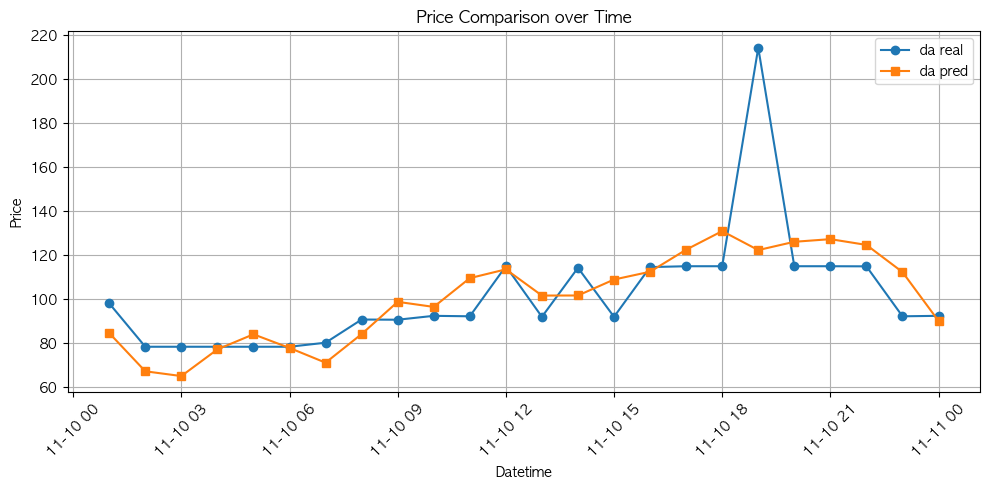

*********** date : 2024-11-11 01:00:00+09:00
Accuracy: 1.0
e1: 0.06719670748781457, e2: 0.0
2024-11-11 - ACC: -0.03656


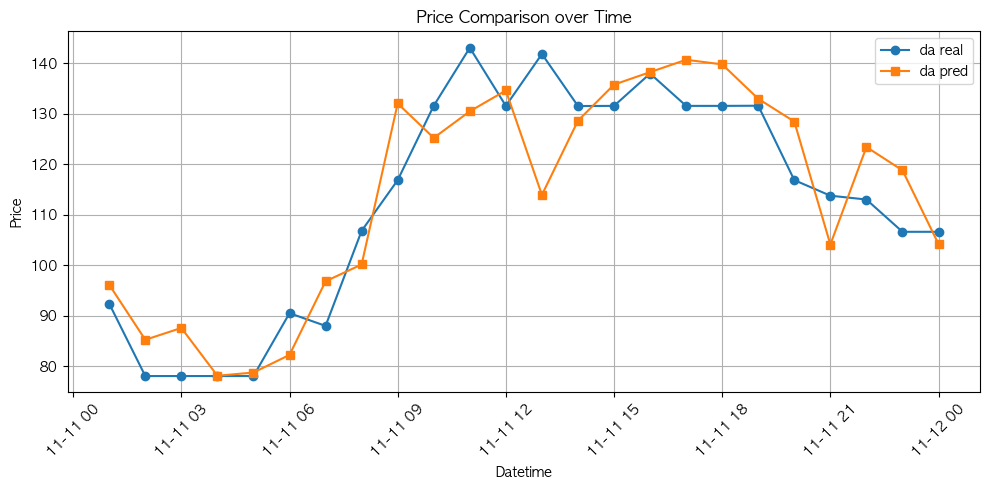

*********** date : 2024-11-12 01:00:00+09:00
Accuracy: 1.0
e1: 0.07122724076912351, e2: 0.0
2024-11-12 - ACC: -0.03575


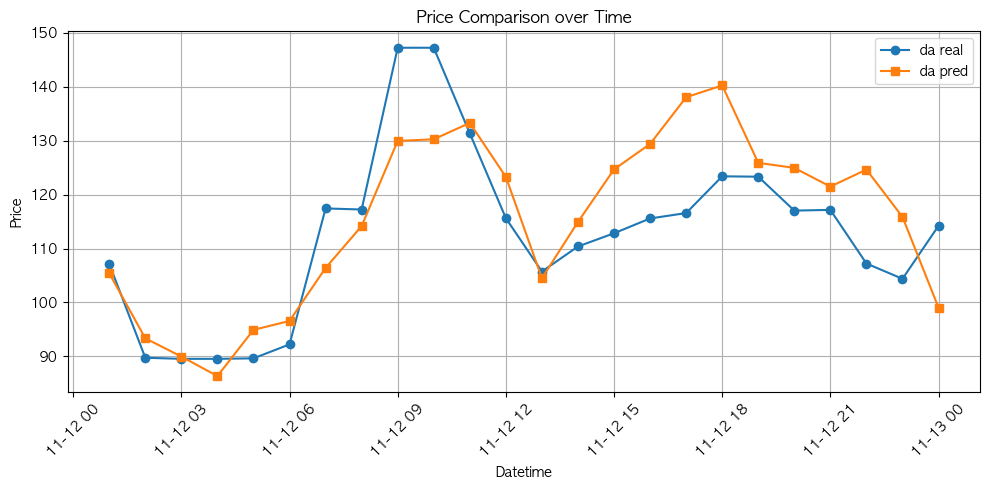

*********** date : 2024-11-13 01:00:00+09:00
Accuracy: 1.0
e1: 0.06810046440950156, e2: 0.0
2024-11-13 - ACC: -0.03638


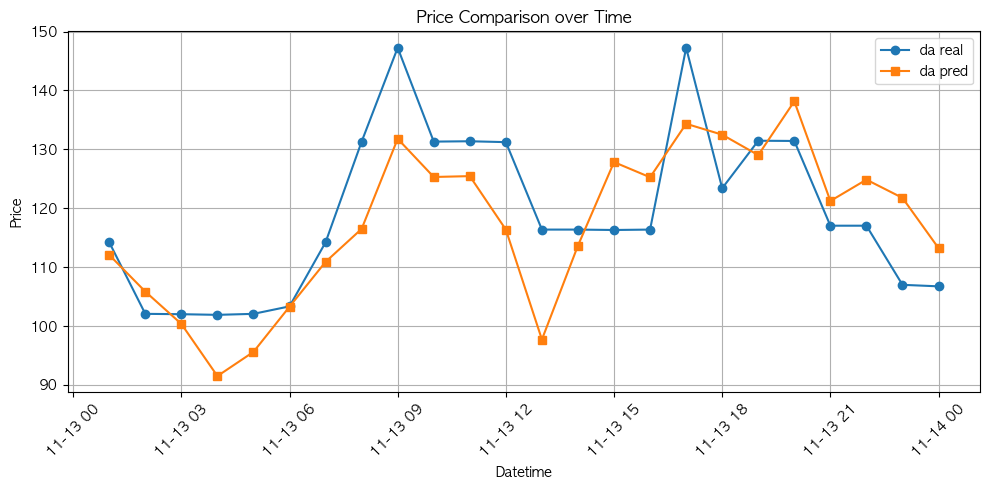

In [136]:
# For measuring accuracy

start_date = '2024-11-10'
end_date = '2024-11-13'

date_range = pd.date_range(start=start_date, end=end_date)

acc_list = []

for date in date_range:
    
    start_time = pd.Timestamp(date, tz='Asia/Seoul') + pd.Timedelta(hours=1)
    end_time = pd.Timestamp(date, tz='Asia/Seoul') + pd.Timedelta(days=1)
    target_date_range = pd.date_range(start=start_time, end=end_time, freq='h', tz='Asia/Seoul')

    # Construct training data
    merged_data = smp_da_data.merge(supply_data, on='ts', how='left')
    merged_data = merged_data[['ts', 'smp_da', 'present_load', 'supply_power']]
    merged_data = merged_data.rename(columns={'smp_da': 'Price', 'present_load': 'Exogenous 1', 'supply_power': 'Exogenous 2'})
    merged_data.index = pd.to_datetime(merged_data['ts'], unit='s', utc=True).dt.tz_convert('Asia/Seoul')
    merged_data = merged_data.drop(columns=['ts'])
    
    train_start = pd.Timestamp('2024-03-01', tz='Asia/Seoul') + pd.Timedelta(hours=1)
    df_train = merged_data[(merged_data.index >= train_start) & (merged_data.index < start_time)]
    df_test = merged_data[(merged_data.index >= start_time) & (merged_data.index <= end_time)]

    # Construct target data
    forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

    # Get the real value for comparison
    real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
    real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

    # Build a model and predict
    model = LEAR()

    forecast_date = forecast.index[0]
    print('*********** date :', forecast_date)
    data_available = pd.concat([df_train, df_test.loc[:forecast_date + pd.Timedelta(hours=23), :]], axis=0)
    data_available.loc[forecast_date:forecast_date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=forecast_date)
    forecast.loc[forecast_date, :] = Yp
    prediction_array = forecast.values.flatten()        

    accu = calculate_measure(forecast.loc[:forecast_date].values.squeeze().reshape(1, 24), real_values.loc[:forecast_date].values.reshape(1, 24))
    print('{} - ACC: {:.5f}'.format(str(forecast_date)[:10], accu))

    # Visualise the predicted price and the real price
    acc_list.append(accu)

    plt.figure(figsize=(10, 5))
    plt.plot(df_test.index, df_test['Price'], label='da real', marker='o')
    plt.plot(df_test.index, prediction_array, label='da pred', marker='s')

    plt.xlabel('Datetime')
    plt.ylabel('Price')
    plt.title('Price Comparison over Time')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()


with open('accuracy.txt', 'w') as f:
    for date, accu in zip(date_range, acc_list):
        f.write('{} - ACC: {:.5f}\n'.format(str(date)[:10], accu))
    mean_accu = np.mean(acc_list)
    f.write('\nAverage ACC: {:.5f}\n'.format(mean_accu))